# SRGAN
根据原文自己搭建，但是训练集使用已有数据集VOC2012

In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm      # 进度条
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.models.vgg import vgg16
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder
from torchvision.utils import save_image

from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
os.makedirs(r"/home/cxmd/文档/git_files/neural_network/SRGAN/run2", exist_ok=True)
os.makedirs(r"/home/cxmd/文档/git_files/neural_network/SRGAN/images2", exist_ok=True)

In [4]:
# 超参数
datapath = '/home/cxmd/文档/data_for_AI_train/VOC2012/train/hr/'
crop_size = 88           # 
upscale_factor = 4       # 超分辨倍数
num_epochs = 100         # 训练轮数
img_size = 256                # 原图片大小
batch_size = 4
channels = 1            # 图像通道数
workers = 2

In [5]:
# transform配置
transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]),
    ]
)

dataset = dset.ImageFolder(
    root=datapath,
    transform=transform
)

data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)


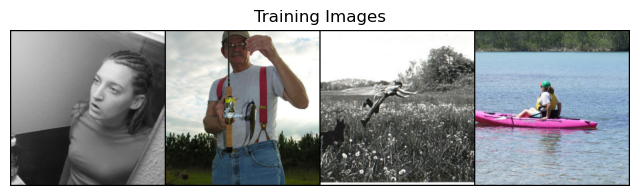

In [6]:
# 绘制部分我们的输入图像
real_batch = next(iter(data_loader))
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis("off")
ax.set_title("Training Images")
ax.imshow(
    vutils.make_grid(
        real_batch[0].to(device)[:4], padding=2, normalize=True
    ).permute(1, 2, 0).cpu()
)
plt.show()

In [7]:
# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual

In [8]:
# 上采样块
class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

In [9]:
# 生成器
class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))
        
        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2
        

In [10]:
netG = Generator(upscale_factor).to(device)
print(netG)

# 写入tensorboard
if sys.platform.startswith('win'):
    writerGpath = r'D:\git_files\neural_network\GAN\run1\Generator'
else:
    writerGpath = r'/home/cxmd/文档/git_files/neural_network/SRGAN/run2/Generator'

writerG = SummaryWriter(writerGpath)

input_to_netG = torch.randn(batch_size, 3, img_size, img_size, device=device)
writerG.add_graph(netG, input_to_model=input_to_netG)
writerG.close()

Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): ResidualBlock(
    (conv1)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))

In [12]:
netD = Discriminator().to(device)
print(netD)

if sys.platform.startswith("win"):
    writerDpath = r'D:\git_files\neural_network\GAN\run1\Discriminator'
else:
    writerDpath = r'/home/cxmd/文档/git_files/neural_network/SRGAN/run2/Discriminator'

writerD = SummaryWriter(writerDpath)
input_to_netD = torch.randn(batch_size, 3, img_size * upscale_factor, img_size * upscale_factor, device=device)
writerD.add_graph(netD, input_to_netD)
writerD.close()

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(256, 256, 

In [13]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

In [16]:
g_loss = GeneratorLoss()
print(g_loss)

GeneratorLoss(
  (loss_network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding

In [17]:
optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

In [ ]:
# 记录开始训练的时间
start_time = time.time()

batches_done = 0
if sys.platform.startswith('win'):
    writerpath = r'D:\git_files\neural_network\SRGAN\run2'
else:
    writerpath = r'/home/cxmd/文档/git_files/neural_network/SRGAN/run2'
writer = SummaryWriter(writerpath)

results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

for epoch in range(num_epochs):
    train_bar = tqdm(data_loader)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}
    
    netG.train()
    netD.train()
    for data, target in train_bar:
        g_update_first = True
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size
        
        ############################
        # (1) Update D network: maximize D(x)-1-D(G(z))
        ###########################
        
        real_img = Variable(target).to(device)
        z = Variable(data).to(device)
        fake_img = netG(z).to(device)
        
        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)
        optimizerD.step()
        
        ############################
        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        ###########################
        netG.zero_grad()
        ## The two lines below are added to prevent runetime error in Google Colab ##
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        ##
        g_loss = g_loss(fake_out, fake_img, real_img).to(device)
        g_loss.backward()
        
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        
        
        optimizerG.step()
        
        # tensorboard跟踪数据
        writer.add_scalar('loss_g', g_loss.item(), epoch*len(data_loader)+i)
        writer.add_scalar('loss_d', d_loss.item(), epoch*len(data_loader)+i)
        
        
        if (i + 1) % 100 == 0:      # 每一百批次输入一次训练程度
            # 计算过去的时间
            elapsed_time = time.time() - start_time
            print('Elapsed time: {:.4f} seconds, Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(elapsed_time, epoch + 1, num_epochs, i + 1, len(data_loader), d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

        if batches_done % sample_interval == 0:
            # writer image to tensorboard
            imgs_to_tensorboard = gen_imgs.data[:25]
            imgs_to_tensorboard = vutils.make_grid(imgs_to_tensorboard, nrow=5, normalize=True).cpu()
            writer.add_image("fake_imgs", imgs_to_tensorboard, epoch*len(data_loader)+i)
            
            save_image(gen_imgs.data[:25], r"/home/cxmd/文档/git_files/neural_network/GAN/images1/%d.png" % batches_done, nrow=5, normalize=True)

        batches_done += 1
writer.close()